In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve


In [2]:
data = pd.read_csv('Merge_AllFeatures.csv')

In [4]:
data

,latitude,lontitude,hour,injury_level,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),...,maneuver_8,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5,motor_6
0,48.896210,2.470120,1,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,48.896210,2.470120,1,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,48.896210,2.470120,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,48.930700,2.368800,2,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,48.935872,2.319174,15,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132972,48.576900,7.726900,7,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
132973,48.771700,2.345760,2,4,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
132974,48.777289,2.223759,15,3,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
132975,48.835124,2.175110,20,4,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# change y order
level4 = data['injury_level']==2, ['injury_level']
level2 = data['injury_level']==4, ['injury_level']
data.loc[level4]=4
data.loc[level2]=2

# normalize numeric values
import numpy as np
normalized_lat = data['latitude']/np.linalg.norm(data['latitude'])
normalized_lon = data['lontitude']/np.linalg.norm(data['lontitude'])
normalized_hr = data['hour']/np.linalg.norm(data['hour'])
data['latitude'] = normalized_lat
data['lontitude'] = normalized_lon
data['hour'] = normalized_hr


from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=1)




## Resampling

In [7]:
df_class_1 = train[train['injury_level'] == 1]
df_class_2 = train[train['injury_level'] == 2]
df_class_3 = train[train['injury_level'] == 3]
df_class_4 = train[train['injury_level'] == 4]

In [8]:
count_class_1, count_class_2, count_class_3, count_class_4 = train['injury_level'].value_counts()

In [9]:
train['injury_level'].value_counts()

1    44232
4    42627
3    16737
2     2785
Name: injury_level, dtype: int64

In [10]:
df_class_2_over = df_class_2.sample(count_class_1, replace=True, random_state=42)
df_class_3_over = df_class_3.sample(count_class_1, replace=True, random_state=42)
df_class_4_over = df_class_4.sample(count_class_1, replace=True, random_state=42)
train = pd.concat([df_class_1, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

X_train = train.iloc[:, train.columns!='injury_level']
y_train = train['injury_level']
X_test = test.iloc[:, train.columns!='injury_level']
y_test = test['injury_level']

In [11]:
y_train.value_counts()

4    44232
3    44232
2    44232
1    44232
Name: injury_level, dtype: int64

## Deal with multicollinearity

In [12]:
X_train = X_train.drop(columns=['motor_6', 'maneuver_26', 'initial_shock_9', 'movable_obstacle_9', 'travel_reason_9',
                                'sex_2', 'user_category_3', 'place_9', 'Max Speed_nan', 'situation of the accident_nan',
                                'surface condition_nan', 'plan layout_nan' , 'total number of traffic lanes_nan',
                                'traffic regime_nan', 'road category_nan' , 'Weekend/Holiday_1.0','collision type_7.0',
                                'atmospheric conditions_9.0', 'intersection_9.0', 'agglomeration_2.0', 'light_5.0',
                                'Not determinable'])

X_test = X_test.drop(columns=['motor_6', 'maneuver_26', 'initial_shock_9', 'movable_obstacle_9', 'travel_reason_9',
                              'sex_2', 'user_category_3', 'place_9', 'Max Speed_nan', 'situation of the accident_nan',
                              'surface condition_nan', 'plan layout_nan' , 'total number of traffic lanes_nan',
                              'traffic regime_nan', 'road category_nan' , 'Weekend/Holiday_1.0','collision type_7.0',
                              'atmospheric conditions_9.0', 'intersection_9.0', 'agglomeration_2.0', 'light_5.0',
                              'Not determinable'])

### Build models

In [15]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                         random_state=1, max_iter=10000)
clf = lr.fit(X_train, y_train)

In [16]:
# Test set Accuracy
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score

ypredict = clf.predict(X_test)
accuracy_score(y_test, ypredict)

0.5765152654534517

In [17]:
# Training set accuracy
train_pred = clf.predict(X_train)
accuracy_score(y_train, train_pred)

0.5624830439500814

In [18]:
X_train

,latitude,lontitude,hour,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),Gloves (2WD / 3WD),...,maneuver_7,maneuver_8,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5
54813,0.002724,0.000679,0.001130,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91139,0.002672,-0.000072,0.001884,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6139,0.002910,0.000348,0.003391,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
27957,0.002699,0.000676,0.004145,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
126218,0.002902,0.000330,0.002073,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4368,0.002723,0.000686,0.002261,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39091,0.002574,0.000857,0.001507,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15664,0.002895,0.000231,0.002826,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
116001,0.002659,-0.000166,0.002638,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# Cross validation accuracy score
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X_train, y_train, scoring="accuracy", cv=3).mean()

0.5606687466087901

## Metrics

In [21]:
# Area under ROC

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}

    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc


    return roc_auc_dict

print("\nLogistic Regression")
# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test, clf.predict(X_test))
print(lr_roc_auc_multiclass)


Logistic Regression
{1: 0.7788769047509865, 2: 0.7361462431627402, 3: 0.6227002042497002, 4: 0.6581105932550385}


In [22]:
import numpy as np

mat = confusion_matrix(y_test, clf.predict(X_test))

FP = mat.sum(axis=0) - np.diag(mat)  
FN = mat.sum(axis=1) - np.diag(mat)
TP = np.diag(mat)
TN = mat.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [23]:
# Recall
TPR

array([0.75924923, 0.58765778, 0.36811454, 0.46657303])

In [24]:
# Precision
PPV

array([0.72911612, 0.12305433, 0.3548538 , 0.67556941])

NameError: name 'plt' is not defined

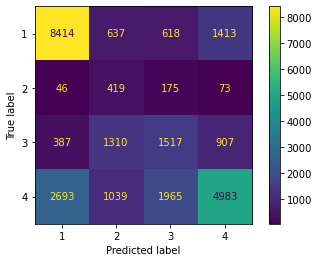

In [27]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)  
ticks = [0, 1, 2, 3]
labels = ['Unharmed', 'Killed', 'Injured hospitalized', 'Slightly Injured']
plt.xticks(ticks, labels, rotation = 20)
plt.yticks(ticks, labels)
plt.show()

## Fairness

In [96]:
# Fairness
# Male accuracy
male = test[test['sex_1']==1]
male = male.drop(columns=['motor_6', 'maneuver_26', 'initial_shock_9', 'movable_obstacle_9', 'travel_reason_9',
                          'sex_2', 'user_category_3', 'place_9', 'Max Speed_nan', 'situation of the accident_nan',
                          'surface condition_nan', 'plan layout_nan' , 'total number of traffic lanes_nan',
                          'traffic regime_nan', 'road category_nan' , 'Weekend/Holiday_1.0','collision type_7.0',
                          'atmospheric conditions_9.0', 'intersection_9.0', 'agglomeration_2.0', 'light_5.0',
                          'Not determinable'])
male_x = male.iloc[:, male.columns!='injury_level']
male_y = male['injury_level']

male_predict = clf.predict(male_x)
accuracy_score(male_y,male_predict)

0.5820986289252543

In [97]:
# Female accuracy
female = test[test['sex_1']==0]
female = female.drop(columns=['motor_6', 'maneuver_26', 'initial_shock_9', 'movable_obstacle_9', 'travel_reason_9',
                              'sex_2', 'user_category_3', 'place_9', 'Max Speed_nan', 'situation of the accident_nan',
                              'surface condition_nan', 'plan layout_nan' , 'total number of traffic lanes_nan',
                              'traffic regime_nan', 'road category_nan' , 'Weekend/Holiday_1.0','collision type_7.0',
                              'atmospheric conditions_9.0', 'intersection_9.0', 'agglomeration_2.0', 'light_5.0',
                              'Not determinable'])
female_x = female.iloc[:, female.columns!='injury_level']
female_y = female['injury_level']

female_predict = clf.predict(female_x)
accuracy_score(female_y,female_predict)

0.5646450399623884

In [98]:
# male false positive rate
import numpy as np

mat = confusion_matrix(male_y, male_predict)

FP = mat.sum(axis=0) - np.diag(mat)  
FN = mat.sum(axis=1) - np.diag(mat)
TP = np.diag(mat)
TN = mat.sum() - (FP + FN + TP)

# False positive rate
false_positive = []
for i in range(4):
    false_positive.append(FP[i]/len(male_y[male_y==i+1]))
FP/(FP+TN)

array([0.22123981, 0.14218118, 0.11108181, 0.09916484])

In [99]:
# female false positive rate
import numpy as np

mat = confusion_matrix(female_y, female_predict)

FP = mat.sum(axis=0) - np.diag(mat)  
FN = mat.sum(axis=1) - np.diag(mat)
TP = np.diag(mat)
TN = mat.sum() - (FP + FN + TP)

# False positive rate
false_positive = []
for i in range(4):
    false_positive.append(FP[i]/len(female_y[female_y==i+1]))

FP/(FP+TN)

array([0.16382381, 0.05897866, 0.14686559, 0.278573  ])

In [100]:
# Male false positive (random forest)
mat_male = np.array([[6629, 175, 504, 559],
                    [50, 225, 231, 45],
                    [361, 441, 1596, 508],
                    [1907, 272, 1510, 3033]])
FP = mat_male.sum(axis=0) - np.diag(mat_male)  
FN = mat_male.sum(axis=1) - np.diag(mat_male)
TP = np.diag(mat_male)
TN = mat_male.sum() - (FP + FN + TP)
FP/(FP+TN)

array([0.22772374, 0.05075736, 0.14828269, 0.09819852])

In [101]:
# Female false positive (random forest)
mat_female = np.array([[2001, 45, 275, 800],
                       [9, 39, 84, 13],
                       [100, 126, 757, 261],
                       [772, 83, 804, 2381]])
FP = mat_female.sum(axis=0) - np.diag(mat_female)  
FN = mat_female.sum(axis=1) - np.diag(mat_female)
TP = np.diag(mat_female)
TN = mat_female.sum() - (FP + FN + TP)
FP/(FP+TN)

array([0.16227666, 0.03022011, 0.15918423, 0.23813747])

### Feature importance for random forest model

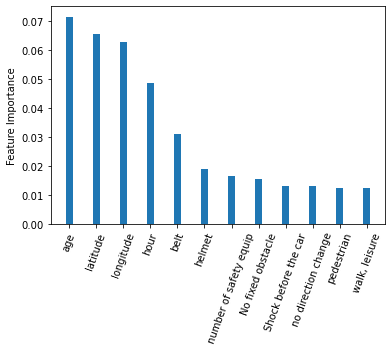

In [94]:
importance = np.array([0.0716482877905661, 0.065607322 , 0.063007617, 0.048819514, 0.031044522, 0.018901427063559278,
                       0.0164306429786191, 0.015538613340996231, 0.013159576849384179, 0.013044601600288136, 0.01233624665516959,
                       0.012235779119952718])

label  = ['age', 'latitude', 'longitude', 'hour', 'belt', 'helmet', 'number of safety equip','No fixed obstacle', 
          'Shock before the car', 'no direction change' ,'pedestrian', 'walk, leisure']


ind = np.arange(12)    # the x locations for the groups
width = 0.25       

fig, ax = plt.subplots()

p1 = ax.bar(ind, importance, width)
ax.set_ylabel('Feature Importance')
ax.set_xticks(ind)
ax.set_xticklabels(label,rotation=70)  

plt.show()
                      
                      